# [Algorithmic Trading in Python - MACD: Construction and Backtest](https://www.youtube.com/watch?v=JzdVPnCSSuo)

## Moving Average Convergence Divergence (MACD)

Trend-following momentum indicator that shows the relationship between two moving averages.

$$
MACD = EMA_{12} - EMA_{26}
$$
where EMA is exponentially weighted moving average

The MACD has a positive value whenever the 12-period EMA is above the 26-period EMA and a negative value when the 12-period EMA is below the 26-period EMA. 

#### MACD Limitations

Divergence can often signal a possible reversal but then no actual reversal actually happens — it produces a *false positive*. Divergence does not forecast all reversals. It can predict many reversals that do not occur eventually and can miss real price reversals.

*False positive* divergence often occurs when the price of an asset moves sideways, such as in a range or triangle pattern following a trend. A slowdown in the momentum—sideways movement or slow trending movement—of the price will cause the MACD to pull away from its prior extremes and gravitate toward the zero lines even in the absence of a true reversal. 

#### [pandas.DataFrame.ewm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html)

[DataFrame.ewm(com=None, span=None, halflife=None, alpha=None, min_periods=0, adjust=True, ignore_na=False, axis=0, times=None, method='single'](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html)

In [56]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import yfinance as yf

In [45]:
ticker = "TSLA"
df = yf.download(ticker, start="2010-01-01")

[*********************100%***********************]  1 of 1 completed


In [46]:
def MACD(df):
    df["EMA12"] = df.Close.ewm(span=12, adjust=False).mean() # adjust=False mathematically correct but insignificant
    df["EMA26"] = df.Close.ewm(span=26, adjust=False).mean()
    df["MACD"] = df.EMA12 - df.EMA26
    df["signal"] = df.MACD.ewm(span=9, adjust=False).mean()

In [47]:
MACD(df)

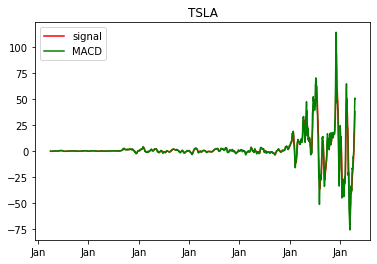

In [48]:
plt.title(ticker)
plt.plot(df.signal, label="signal", color="red")
plt.plot(df.MACD, label="MACD", color="green")
plt.gca().xaxis.set_major_formatter(DateFormatter("%b", tz=None))
plt.legend()
plt.show()

In [49]:
# Buying signal loop over dataframe if MACD is above the signal value and if was the case the day before
# Selling signal loop over dataframe if MACD is below the signal value and it was not thee case the day before
# exclude first two
Buy, Sell = [], []
for i in range(2, len(df)):
    if df.MACD.iloc[i] > df.signal.iloc[i] and df.MACD.iloc[i-1] < df.signal.iloc[i-1]:
        Buy.append(i)
    elif df.MACD.iloc[i] < df.signal.iloc[i] and df.MACD.iloc[i-1] > df.signal.iloc[i-1]:
        Sell.append(i)

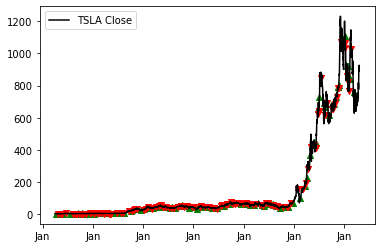

In [50]:
plt.scatter(df.iloc[Buy].index, df.iloc[Buy].Close, marker="^", color="green")
plt.scatter(df.iloc[Sell].index, df.iloc[Sell].Close, marker="v", color="red")
plt.plot(df.Close, label=ticker+" Close", color='k')
plt.gca().xaxis.set_major_formatter(DateFormatter("%b", tz=None))
plt.legend()
plt.show()

In [51]:
Realbuys = [i+1 for i in Buy] # cannot buy at Close price on day i; must buy next day (i+1)
Realsells = [i+1 for i in Sell]
Buyprices = df.Open.iloc[Realbuys]
Sellprices = df.Open.iloc[Realsells]

In [52]:
# sometimes buy is not the first case and sell is not the last case
if Sellprices.index[0] < Buyprices.index[0]:
    Sellprices = Sellprices.drop(sellprices.index[0])
elif Buyprices.index[-1] > Sellprices.index[-1]:
    Buyprices = Buyprices.drop(Buyprices.index[-1])

In [53]:
profitsrel = []
for i in range(len(Sellprices)):
    profitsrel.append((Sellprices[i] - Buyprices[i]) / Buyprices[i])

In [59]:
pd.DataFrame(profitsrel).mean()

0    0.043879
dtype: float64